# Fish Passage Modeling Tool Testing

This notebook tests the functions in FishPass tool using an abbreviated dataset. Original geospatial data inputs from Will were reprojected, merged, or otherwise modified to simplify the testing process.

#### Import modules

In [1]:
import geopandas as gpd
import pandas
import matplotlib.pyplot as plt
import FishPass

#### Read FishPass tool documentation

The FishPass tool includes documentation for the tool itself and for each individual function. Read the documentation in its entirety by calling the ```help()``` function and passing the module name as an argument.

In [2]:
help(FishPass)

Help on module FishPass:

NAME
    FishPass - A Python Fish Passage Model

DESCRIPTION
    This tool uses three functions to apply a proportional upstream passage model to a stream network with passage restrictions. It is designed to model fish passage over beaver dams, but could potentially be applied to other restrictions.
    
    The stream network must have reaches with unique IDs, and a table that describes the relationship between a given reach and the reach immediately downstream (the "from-to" table). Passage restrictions must reference a reach ID, and reaches can have more than one passage restriction. Stream attributes used to split populations proportionally at confluences must be continuous values and must be available for all reaches in the network. To identify main stem reaches using this tool, the reaches must be grouped by tributaries or other meaningful hydrologic units. Alternatively, main stems can be defined outside of this tool using other stream attributes (eg, s

Alternatively, the help documentation for an individual function can be viewed by passing both the module name and function name as arguments to ```help()```.

In [3]:
help(FishPass.find_main_stems)

Help on function find_main_stems in module FishPass:

find_main_stems(tr, ft)
    Uses a collection of tributaries and the reaches therein to look for any reach within a tributary that flows "from" a reach outside of the tributary; those reaches are marked as being "non-terminal" (ie, the reach continues past the tributary boundary and into another one upstream). All non-terminal reaches are then propagated downstream until the opposite is true (ie, until we find a reach that flows "to" a reach outside of the tributary downstream). All reaches in between these two points are combined into a list of main stem reaches.
    
        If the stream network is not grouped by tributaries or other meaningful hydrologic units, consider defining the main stems list outside of this function using other stream attributes (eg, stream order, stream name) or manually in a GIS. 
    
    Parameters
    ----------
    tr : pandas dataframe, required
        A dataframe with tributary ID in the first co

As the documentation states, we need to create some specific tabular data and lists to use as inputs to the functions. We will start by loading geospatial data and doing some basic joining operations.

#### Load & prep geospatial data 
  
This may take a few minutes, as the merged NetMap streams file is large (350MB) and must be read to memory.

In [4]:
tribs = gpd.read_file('F:/GIS/OTHER/WS/FishPass/shp/Tribs.shp')
streams = gpd.read_file('F:/GIS/OTHER/WS/FishPass/shp/netmap_reach_uID.shp')
dams = gpd.read_file('F:/GIS/OTHER/WS/FishPass/shp/Beaver_Points_3338.shp')

Check coordinate reference systems to ensure they are all the same. 

In [5]:
print(tribs.crs)
print(streams.crs)
print(dams.crs)

epsg:3338
epsg:3338
epsg:3338


Define two separate stream networks with all reaches > order 1. The first is a full stream network, and the second is a grayling habitat stream network limited by gradient and mean annual flow.

In [6]:
streams_full = streams[streams['STRM_ORDER'] > 1].copy()
streams_habitat = streams[(streams['STRM_ORDER'] > 1) & (streams['GRADIENT'] < 0.04) & (streams['MEANANNCMS'] > 0.06)].copy()

In order to join reaches to the tributaries that contain then, we need to add representative geometry point to each reach line. This is necessary because many reach lines extend past the tributary polygon boundaries, and so an intersection of lines to polygons would produce many duplicate joins (ie, a reach line is joined to two tributaries.)

We want to avoid duplicates in the results, so we will create a representative point for each reach and use that point to join with tributaries.

In [7]:
streams_full['rep_pt'] = streams_full.geometry.representative_point()

#change geometry from polygon to rep point and reassign to new geodataframe
reach_rep = streams_full.set_geometry('rep_pt')

#spatial join rep points to tribs using intersect predicate
#this approximates "have their center in" joins in ESRI ... might be unpredictable if stream line is really long and sinuous, but for short NetMap reaches this works fine
trib_reach = gpd.sjoin(tribs, reach_rep, how="left", predicate="intersects") 

To associate dams with stream reaches, we need to join dam points to the stream network using a "nearest" predicate. This join will work even if the dam point is not exactly on the stream line.

In [8]:
reach_dams = gpd.sjoin_nearest(dams, streams_full, how="left") 

#### Format tables for tool input

Now we can reformat our geospatial data to tabular inputs for the tool. For all functions, the input tables will have a "uID" column for unique reach ID, and the input lists will be lists of uIDs.

The tributary table will be a one-to-many relationship between HUC12 polygons and reach uIDs. We can see that for each HUC12 ID, there are many uIDs.

In [9]:
trib_tbl = trib_reach[['HUC12', 'uID']]
print(trib_tbl)

            HUC12       uID
0    190803031406  good2663
0    190803031406  good2662
0    190803031406  good2661
0    190803031406  good2660
0    190803031406  good2655
..            ...       ...
130  190803031402  good2764
130  190803031402  good2763
130  190803031402  good2762
130  190803031402  good2761
130  190803031402  good1980

[61540 rows x 2 columns]


The dam table also allows for one-to-many relationships, as there may be >1 dam per stream reach. NA values and duplicate values in the Dam_Num are OK here, because the script will simply count the number of rows per reach in this table to identify number of beaver dams.

In [10]:
dam_df = reach_dams[['uID', 'Dam_Num']].copy()
print(dam_df)

            uID Dam_Num
0     chat11869      12
1     chat11844       2
2     chat11852       3
3     chat12307       6
4     chat12455       8
..          ...     ...
838  shaw564951     NaN
838    good2900     NaN
838   salc56003     NaN
838   salc50933     NaN
838   salc50078     NaN

[848 rows x 2 columns]


The stream attribute table must be a continuous value attribute (such as flow, gradient, width) because it will be used to assign proportions for splitting the fish population as confluences. There must be a value for each reach, or the tool will fail. In this test, we use mean annual flow to assign proportions at confluences.

In [11]:
maf = streams_full[['uID', 'MEANANNCMS']].copy()
print(maf)

               uID  MEANANNCMS
0            chat1     18.3002
1            chat2     18.3000
2            chat3     18.2998
3            chat4     18.2997
4            chat5     18.2996
...            ...         ...
201066  shaw570482      0.1062
201067  shaw570483      0.1062
201068  shaw570484      0.1058
201069  shaw570485      0.1052
201070  shaw570486      0.1041

[106955 rows x 2 columns]


Use the NetMap reach relationship attributes to define a "from-to" input table. Define a separate "from-to" table using the grayling habitat streams.

This will allow us to limit the stream network by simply swapping this table in the function input. While the habitat "from-to" table will contain upstream "islands" of grayling habitat, the iteration function that moves upstream from the origin will stop at the first reach that does not meet the habitat parameters because there will be no data for the "from" uID in the table. We can see below, there are fewer rows in the habitat "from-to" table.

In [12]:
from_to = streams_full[['uID', 'DOWN_uID']].copy()
from_to_habitat = streams_habitat[['uID', 'DOWN_uID']].copy()

print(from_to)
print(from_to_habitat)

               uID    DOWN_uID
0            chat1       chat0
1            chat2       chat1
2            chat3       chat2
3            chat4       chat3
4            chat5       chat4
...            ...         ...
201066  shaw570482  shaw570481
201067  shaw570483  shaw570482
201068  shaw570484  shaw570483
201069  shaw570485  shaw570484
201070  shaw570486  shaw570485

[106955 rows x 2 columns]
               uID    DOWN_uID
0            chat1       chat0
1            chat2       chat1
2            chat3       chat2
3            chat4       chat3
4            chat5       chat4
...            ...         ...
201066  shaw570482  shaw570481
201067  shaw570483  shaw570482
201068  shaw570484  shaw570483
201069  shaw570485  shaw570484
201070  shaw570486  shaw570485

[61313 rows x 2 columns]


#### Testing with plots

Now that our base tables are set up, we can use a limited dataset for testing purposes. Let's pick five HUC12 polygons that we know are adjacent to one another, and subset our base tributaries table to include only those HUC12s. 

(These HUC12s are in the Munson Creek area.)

In [13]:
munson_huc12s = ['190803060201', '190803060202', '190803060203', '190803060204', '190803060305']
munson_tribs = trib_tbl[(trib_tbl['HUC12'].isin(munson_huc12s))]

Use the ```find_main_stems()``` function with our test tributary table and the full "from-to" input table. This will find all main stems within those 5 test tributaries. Since there is a quite a bit of iteration in this function, it may take a while if running on a large list of tributaries with many reaches.

In [14]:
munson_main = FishPass.find_main_stems(munson_tribs, from_to)

Checking inputs...
Processing 5 unique tributaries...
Found 477 unique main stem reaches.


Next, use the ```find_origins()``` function with the main stem result list and the full "from-to" input table. This will find all reaches that flow directly into the main stems, and typically runs much faster than the ```find_main_stems()``` function.

In [15]:
munson_origins = FishPass.find_origins(munson_main, from_to)

Checking inputs...
Found 25 unique origin reaches flowing into main stems.


To make sure we are on the right track and these results make sense spatially, lets plot the main stems and the origins on top of the tributaries and stream network. 

In [16]:
#first subset the original geodataframes using the test trib list, the main stem list, and the origins list
#we will use the reach rep points dataframe for the origins list for clarity in the plot

tribs_gdf = tribs[tribs['HUC12'].isin(munson_huc12s)]
mainstems_gdf = streams_full[streams_full['uID'].isin(munson_main)]
origins_gdf = reach_rep[reach_rep['uID'].isin(munson_origins)]

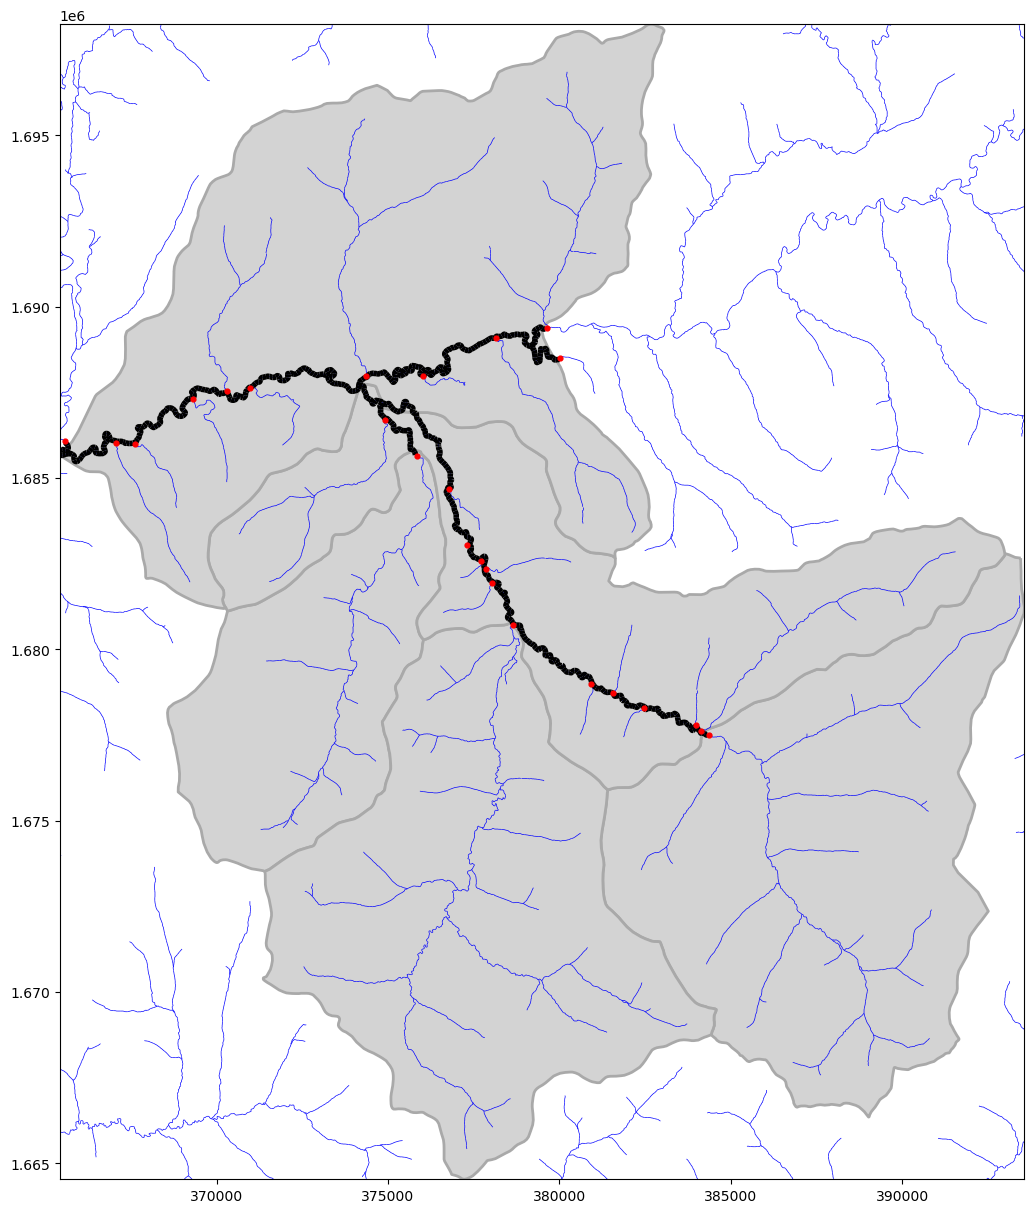

In [17]:
fig, ax = plt.subplots(figsize=(30, 15))

#background tribs and stream network... full network is thin blue lines
tribs_gdf.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth = 2, zorder=1)
streams_full.plot(ax=ax, color='blue', linewidth = .5, zorder=2)

#main stems in thick black
mainstems_gdf.plot(ax=ax, color='black', linewidth=4, zorder=3)

#origins in red
origins_gdf.plot(ax=ax, color='red', markersize=12, zorder=10)


#set view extent based on tributary bounds
xlim = ([tribs_gdf.total_bounds[0],  tribs_gdf.total_bounds[2]])
ylim = ([tribs_gdf.total_bounds[1],  tribs_gdf.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

#plt.savefig('F:/GIS/OTHER/WS/FishPass/mainstems_and_origins_test.jpg')

plt.show();

This map looks correct, so now we can use these results in the fish passage model. We will start by using the entire stream network for modeling.

Parameters will be:
- dams table
- origins list
- from-to table for full stream network
- 50% as the percent of population able to pass a dam
- 5% as the percent cutoff to stop travel upstream
- mean annual flow to split population proportionally at confluences

The function will return a list of dataframes, one for each origin in the origins list input. This output provides some flexibility if the user wants to run the model on a large stream network, and then call results from individual tributaries for further analysis.

In [18]:
munson_fishpass = FishPass.fish_passage(dam_df, munson_origins, from_to, 50, 5, maf)

Checking inputs...
Function will use stream attribute MEANANNCMS to split population proportionally at confluences...
Analyzing fish passage upstream of chen14364.......
Analyzing fish passage upstream of chen15347.......
Analyzing fish passage upstream of chen10824.......
Analyzing fish passage upstream of chen1901.......
Analyzing fish passage upstream of chen14246.......
Analyzing fish passage upstream of chen12948.......
Analyzing fish passage upstream of chen14334.......
Analyzing fish passage upstream of chen12893.......
Analyzing fish passage upstream of chen12865.......
Analyzing fish passage upstream of chen15496.......
Analyzing fish passage upstream of chen12723.......
Analyzing fish passage upstream of chen14506.......
Analyzing fish passage upstream of chen15725.......
Analyzing fish passage upstream of chen11466.......
Analyzing fish passage upstream of chen12812.......
Analyzing fish passage upstream of chen14219.......
Analyzing fish passage upstream of chen15149.......

Checking a few of the results, we see a collection of tables with reach uID in one columns, and percent population passing in the next. The lower range in percent passing is variable with some streams reaching the 5% threshold and some with no restrictions and 100% passing throughout.

In [19]:
munson_fishpass[2:7]

[          uID    pass
 0   chen10824  100.00
 1   chen10825  100.00
 2   chen10826  100.00
 3   chen10827  100.00
 4   chen10828  100.00
 5   chen10829  100.00
 6   chen10830  100.00
 7   chen10831  100.00
 8   chen10832  100.00
 9   chen10833  100.00
 10  chen10834  100.00
 11  chen10835  100.00
 12  chen10836  100.00
 13  chen10837   50.00
 14  chen10838   12.50
 15  chen10839   12.50
 16  chen10840   12.50
 17  chen10841    6.25,
           uID        pass
 0    chen1901  100.000000
 1    chen1902   70.608841
 2   chen10297   14.695580
 3    chen1903   70.608841
 4   chen10298   14.695580
 ..        ...         ...
 64   chen1931    6.602807
 65   chen1932    6.602807
 66   chen1933    6.602807
 67   chen1934    6.602807
 68   chen1935    6.602807
 
 [69 rows x 2 columns],
           uID  pass
 0   chen14246   100
 1   chen14247   100
 2   chen14248   100
 3   chen14249   100
 4   chen14250   100
 5   chen14251   100
 6   chen14252   100
 7   chen14253   100
 8   chen14254   100
 9

To plot these, we can concatenate all of the results into one dataframe and join the values to the stream network geodataframe. This will preserve our percent passing results, but add the geometry of the stream network for plotting.

We will leave the origins out of this plot, but include the dams.

In [20]:
df = pandas.concat(munson_fishpass)
munson_fishpass_gdf = df.merge(streams, how='left', on='uID').set_geometry('geometry')

C:\Users\jdpaul3\Anaconda3\envs\ws_beaver\lib\site-packages\matplotlib\axes\_base.py:2917: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


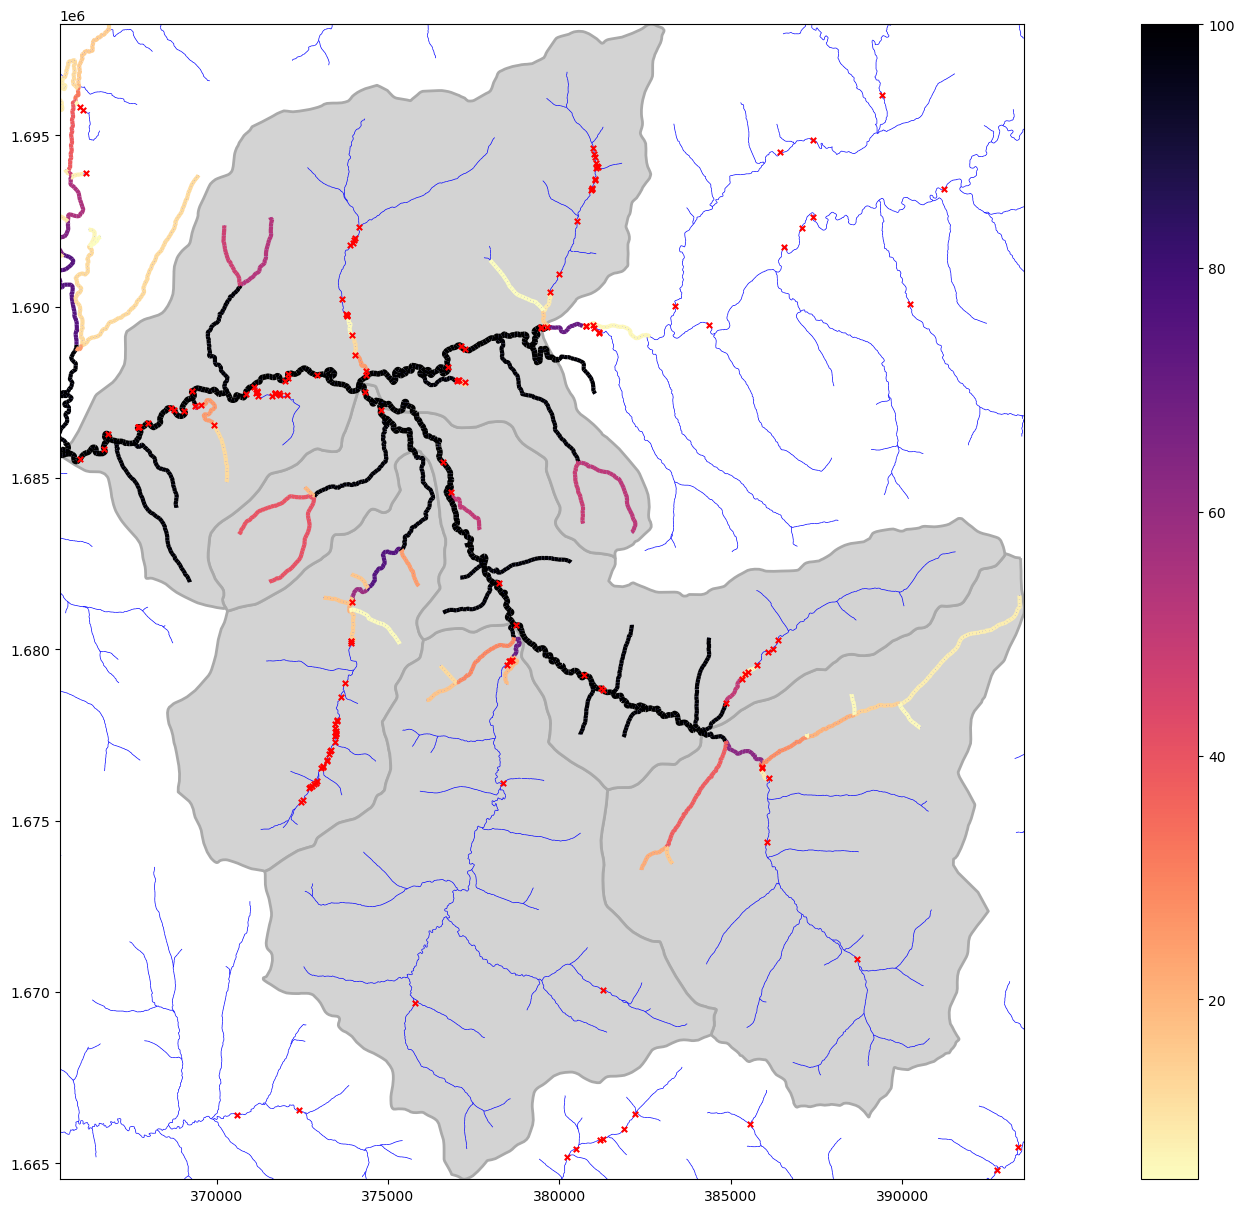

In [21]:
fig, ax = plt.subplots(figsize=(30, 15))

#background tribs and stream network... full network is thin blue lines
tribs_gdf.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth = 2, zorder=1)
streams_full.plot(ax=ax, color='blue', linewidth = .5, zorder=2)

#main stems in thick black
mainstems_gdf.plot(ax=ax, color='black', linewidth=4, zorder=3)

#reaches with fish passage, plotted on a color ramp
munson_fishpass_gdf.plot(ax=ax, column='pass', linewidth=3, cmap = 'magma_r', legend=True)

#dams in red x's
dams.plot(ax=ax, color='red', marker='x', markersize=15, zorder=10)


#set view extent based on tributary bounds
xlim = ([tribs_gdf.total_bounds[0],  tribs_gdf.total_bounds[2]])
ylim = ([tribs_gdf.total_bounds[1],  tribs_gdf.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

#plt.savefig('F:/GIS/OTHER/WS/FishPass/mainstems_and_origins_test.jpg')

plt.show();

This map looks correct, so now we can try the same parameters but using the limited habitat stream network for modeling.

Parameters will be:
- dams table
- origins list
- from-to table for habitat stream network
- 50% as the percent of population able to pass a dam
- 5% as the percent cutoff to stop travel upstream
- mean annual flow to split population proportionally at confluences


In [22]:
munson_fishpass_hab = FishPass.fish_passage(dam_df, munson_origins, from_to_habitat, 50, 5, maf)

Checking inputs...
Function will use stream attribute MEANANNCMS to split population proportionally at confluences...
Analyzing fish passage upstream of chen14364.......
Analyzing fish passage upstream of chen15347.......
Analyzing fish passage upstream of chen10824.......
Analyzing fish passage upstream of chen1901.......
Analyzing fish passage upstream of chen14246.......
Analyzing fish passage upstream of chen12948.......
Analyzing fish passage upstream of chen14334.......
Analyzing fish passage upstream of chen12893.......
Analyzing fish passage upstream of chen12865.......
Analyzing fish passage upstream of chen15496.......
Analyzing fish passage upstream of chen12723.......
Analyzing fish passage upstream of chen14506.......
Analyzing fish passage upstream of chen15725.......
Analyzing fish passage upstream of chen11466.......
Analyzing fish passage upstream of chen12812.......
Analyzing fish passage upstream of chen14219.......
Analyzing fish passage upstream of chen15149.......

Again, we can concatenate all of the results into one dataframe and join the values to the stream network geodataframe. This will preserve our percent passing results, but add the geometry of the stream network for plotting.

Note that we can join to the full stream network geodataframe, since the results have already been limited to the grayling habitat by using the habitat "from-to" table.

In [23]:
df = pandas.concat(munson_fishpass_hab)
munson_fishpass_hab_gdf = df.merge(streams, how='left', on='uID').set_geometry('geometry')

This time we will plot the full stream network as thin dashed lines, the grayling habitat network as solid lines, and the percent passing results on top.

C:\Users\jdpaul3\Anaconda3\envs\ws_beaver\lib\site-packages\matplotlib\axes\_base.py:2917: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


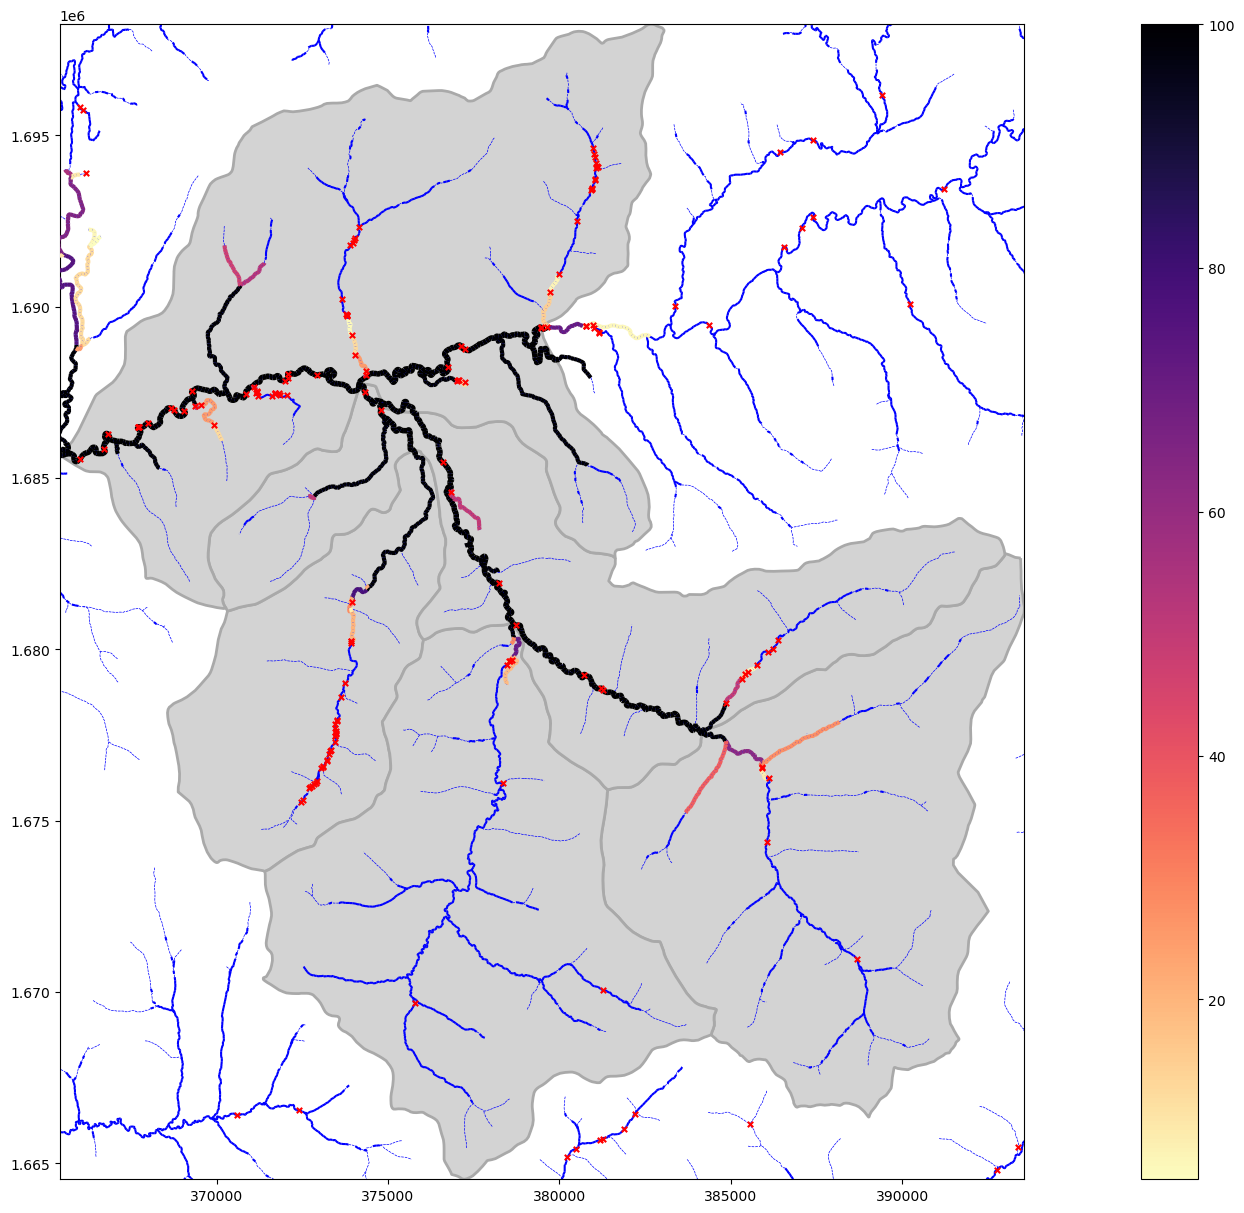

In [24]:
fig, ax = plt.subplots(figsize=(30, 15))

#background tribs and stream network... full network is thin blue lines
tribs_gdf.plot(ax=ax, color='lightgray', edgecolor='darkgray', linewidth = 2, zorder=1)
streams_full.plot(ax=ax, color='blue', linewidth = .5, linestyle='dashed', zorder=2)
streams_habitat.plot(ax=ax, color='blue', linewidth = 1.5, zorder=2.5)

#main stems in thick black
mainstems_gdf.plot(ax=ax, color='black', linewidth=4, zorder=3)

#reaches with fish passage, plotted on a color ramp
munson_fishpass_hab_gdf.plot(ax=ax, column='pass', linewidth=3, cmap = 'magma_r', zorder=9, legend=True)

#dams in red x's
dams.plot(ax=ax, color='red', marker='x', markersize=15, zorder=10)


#set view extent based on tributary bounds
xlim = ([tribs_gdf.total_bounds[0],  tribs_gdf.total_bounds[2]])
ylim = ([tribs_gdf.total_bounds[1],  tribs_gdf.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

#plt.savefig('F:/GIS/OTHER/WS/FishPass/mainstems_and_origins_test.jpg')

plt.show();

#### Testing with table joins

The functions seem to perform well spatially, but further analysis can be done by joining these results with stream attributes like length. To perform those analyses we will need to get the total length of the stream networks to make some comparisons.

If we are interested in summarizing results at the tributary level, one way to do that is to simply do a spatial join of tributaries table to the stream network length attribute by uID. We then join the full list of concatenated uIDs to the same table, group by HUC12 and sum the aggregated rows.

In [25]:
trib_length = munson_tribs.merge(streams_full[['uID', 'LENGTH_M']], how='left', on='uID')
trib_length['TOTAL_LENGTH_KM'] = trib_length['LENGTH_M']/1000

pass_length = munson_fishpass_gdf[['uID']].merge(streams_full[['uID', 'LENGTH_M']], how='left', on='uID')
pass_length['PASS_LENGTH_KM'] = pass_length['LENGTH_M']/1000

In [26]:
pass_df = trib_length[['HUC12', 'uID', 'TOTAL_LENGTH_KM']].merge(pass_length[['uID', 'PASS_LENGTH_KM']], how='left', on='uID')

In [27]:
pass_df.groupby('HUC12').sum(numeric_only=True)

,TOTAL_LENGTH_KM,PASS_LENGTH_KM
HUC12,,
190803060201,60.271184,20.712989
190803060202,76.360140,7.229424
190803060203,29.422178,13.355511
190803060204,62.742013,29.706217
190803060305,99.502840,39.313849


We can do this same joining process using the habitat stream network results. As expected, we see these length values are all less than the full stream network.

In [28]:
trib_hab_length = munson_tribs.merge(streams_habitat[['uID', 'LENGTH_M']], how='left', on='uID')
trib_hab_length['TOTAL_LENGTH_KM'] = trib_hab_length['LENGTH_M']/1000

pass_hab_length = munson_fishpass_hab_gdf[['uID']].merge(streams_habitat[['uID', 'LENGTH_M']], how='left', on='uID')
pass_hab_length['PASS_LENGTH_KM'] = pass_hab_length['LENGTH_M']/1000

In [29]:
pass_hab_df = trib_hab_length[['HUC12', 'uID', 'TOTAL_LENGTH_KM']].merge(pass_hab_length[['uID', 'PASS_LENGTH_KM']], how='left', on='uID')

In [30]:
pass_hab_df.groupby('HUC12').sum(numeric_only=True)

,TOTAL_LENGTH_KM,PASS_LENGTH_KM
HUC12,,
190803060201,29.935756,8.592979
190803060202,50.021116,3.146201
190803060203,15.283684,8.663857
190803060204,37.607624,10.480502
190803060305,75.375456,23.169525


The final demonstration is using the ```fish_pass()``` function to define full stream networks at the origin level. Since the ```fish_pass()``` function actually outputs a list of dataframes (one for each origin input), we can also do some analysis on that level. But we will need to know the full length of the stream network upstream from each origin, and not for the tributary at large.

To do this, a special parameter is built into the tool. If we run the same functions again, but use the "NONE" string as stream attribute input, this will not split the population at confluences and will return all uIDs in the habitat stream network upstream of the origin uIDs. To do this, we must also let 100% of fish pass each barrier and use 1% as the cutoff. 

In [31]:
munson_fishpass_none = FishPass.fish_passage(dam_df, munson_origins, from_to, 100, 1, 'NONE')
munson_fishpass_hab_none = FishPass.fish_passage(dam_df, munson_origins, from_to_habitat, 100, 1, 'NONE')

Checking inputs...
Function will not split population proportionally at confluences...
Analyzing fish passage upstream of chen14364.......
Analyzing fish passage upstream of chen15347.......
Analyzing fish passage upstream of chen10824.......
Analyzing fish passage upstream of chen1901.......
Analyzing fish passage upstream of chen14246.......
Analyzing fish passage upstream of chen12948.......
Analyzing fish passage upstream of chen14334.......
Analyzing fish passage upstream of chen12893.......
Analyzing fish passage upstream of chen12865.......
Analyzing fish passage upstream of chen15496.......
Analyzing fish passage upstream of chen12723.......
Analyzing fish passage upstream of chen14506.......
Analyzing fish passage upstream of chen15725.......
Analyzing fish passage upstream of chen11466.......
Analyzing fish passage upstream of chen12812.......
Analyzing fish passage upstream of chen14219.......
Analyzing fish passage upstream of chen15149.......
Analyzing fish passage upstrea

Since the dataframes are all named after their origin reach uIDs, we can iterate through the origin list and find all appropriate dataframes. Then we run the same length joining process as above, and concatenate the results.

In [32]:
o_lengths_df = pandas.DataFrame(columns=['origin', 'TOTAL_LENGTH_KM', 'PASS_LENGTH_KM'])

for o in munson_origins:
    
    for df in munson_fishpass:
        if df.name == o:
            pass_len = df[['uID']].merge(streams_full[['uID', 'LENGTH_M']], how='left', on='uID')
            pass_len['PASS_LENGTH_KM'] = pass_len['LENGTH_M']/1000  
            
    for df in munson_fishpass_none:
        if df.name == o:
            total_len = df[['uID']].merge(streams_full[['uID', 'LENGTH_M']], how='left', on='uID')
            total_len['TOTAL_LENGTH_KM'] = total_len['LENGTH_M']/1000
        
    if (len(total_len) > 0) & (len(pass_len) > 0):
        
        sum_df = total_len[['uID', 'TOTAL_LENGTH_KM']].merge(pass_len[['uID', 'PASS_LENGTH_KM']], how='left', on='uID')
        
        row = [o]
        
        row.append(sum_df[['TOTAL_LENGTH_KM']].sum()[0])
        row.append(sum_df[['PASS_LENGTH_KM']].sum()[0])
    
        o_lengths_df.loc[len(o_lengths_df)] = row
    
        
    #break

In [33]:
o_lengths_df

,origin,TOTAL_LENGTH_KM,PASS_LENGTH_KM
0,chen14364,1.888882,1.888882
1,chen15347,3.720673,0.447843
2,chen10824,1.905661,1.905661
3,chen1901,493.010588,7.542856
4,chen14246,2.922228,2.922228
5,chen12948,76.254429,7.229424
6,chen14334,0.159497,0.159497
7,chen12893,1.701397,1.701397
8,chen12865,2.286600,2.286600
9,chen15496,8.733648,8.733648


#### Input Error Testing

Intentionally produced errors in inputs, to test error catching functionality.

In [34]:
# string instead of table
test = FishPass.fish_passage('string input error', munson_origins, from_to, 100, 1, "NONE")

Checking inputs...
Function will not split population proportionally at confluences...


SystemExit: Dams input must be pandas dataframe...check inputs

C:\Users\jdpaul3\Anaconda3\envs\ws_beaver\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [35]:
# wrong SA string input
test = FishPass.fish_passage(dam_df, munson_origins, from_to, 100, 1, "NA")

Checking inputs...


SystemExit: Stream attribute input must be string "NONE" or a pandas dataframe...check inputs

In [36]:
# bad number
test = FishPass.fish_passage(dam_df, munson_origins, from_to, 150, 1, maf)

Checking inputs...
Function will use stream attribute MEANANNCMS to split population proportionally at confluences...


SystemExit: Percent passing parameter must be an integer, with possible values of 0 to 100...check inputs

In [37]:
# bad number
test = FishPass.fish_passage(dam_df, munson_origins, from_to, 50, 0, maf)

Checking inputs...
Function will use stream attribute MEANANNCMS to split population proportionally at confluences...


SystemExit: Percent cutoff parameter must be an integer, with possible values of 1 to 100...check inputs

In [38]:
# string instead of table
test = FishPass.find_main_stems('string input error', from_to)

Checking inputs...


SystemExit: Tributaries input must be pandas dataframe...check inputs

In [39]:
# string instead of list
test = FishPass.find_origins('string input error', from_to)

Checking inputs...


SystemExit: Main stem input must be list...check inputs